In [1]:
import tensorflow as tf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, Bidirectional
from keras import Sequential


In [2]:
class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if np.mod(epoch, 80) ==0 :  # or save after some epoch, each k-th epoch etc.
            self.model.save("cnn_lstm_save/model_{}".format(epoch))


In [3]:
# split into training set and validation set
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

# more slices
timesteps = 16
train_slices = np.zeros([np.size(X_train, 0), timesteps, np.size(X_train, 1), int(np.size(X_train, 2)/timesteps), np.size(X_train, 3)])
test_slices = np.zeros([np.size(x_test, 0), timesteps, np.size(X_train, 1), int(np.size(X_train, 2)/timesteps), np.size(X_train, 3)])
for k in range(timesteps):
    train_slices[:, k, :, :, :] = X_train[:, :, int(k*np.size(X_train, 2)/timesteps):int((k+1)*np.size(X_train, 2)/timesteps), :]
    test_slices[:, k, :, :, :] = x_test[:, :, int(k*np.size(X_train, 2)/timesteps):int((k+1)*np.size(X_train, 2)/timesteps), :]

x_train, x_val, y_train, y_val = train_test_split(train_slices, Y_train, test_size=0.1)

In [ ]:
input_shape = (16, 128, 8, 3)
model = Sequential()
model.add(TimeDistributed(Conv2D(filters=16, kernel_size=(3, 3), 
                                 padding='same', activation='relu', input_shape=input_shape)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='valid')))
model.add(Dropout(0.3))
model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), 
                                 padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='valid')))
model.add(Dropout(0.3))
model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), 
                                 padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='valid')))
model.add(Dropout(0.3))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dense(128, activation='relu')))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(256))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss="sparse_categorical_crossentropy",
                metrics='accuracy')
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
saver = CustomSaver()
model.fit(x=x_train,
        y=y_train,
        epochs=100,
        batch_size=128,
        validation_data=(x_val, y_val),
        shuffle=True,
        callbacks=[tensorboard_callback, saver])

model.summary()
%tensorboard --logdir logs/fit

In [8]:
model = tf.keras.models.load_model("cnn_lstm_save/model_100")
tf.keras.utils.plot_model(model, to_file='cnn_lstm_save/cnn_lstm.png', show_shapes=True, show_dtype=True
                          , show_layer_names=False, show_layer_activations=True)
scores = model.evaluate(test_slices,y_test)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

32/32 [==============================] - 2s 34ms/step - loss: 0.3306 - accuracy: 0.9180
Test loss: 0.33061110973358154
Test accuracy: 0.9179999828338623


32/32 [==============================] - 1s 33ms/step


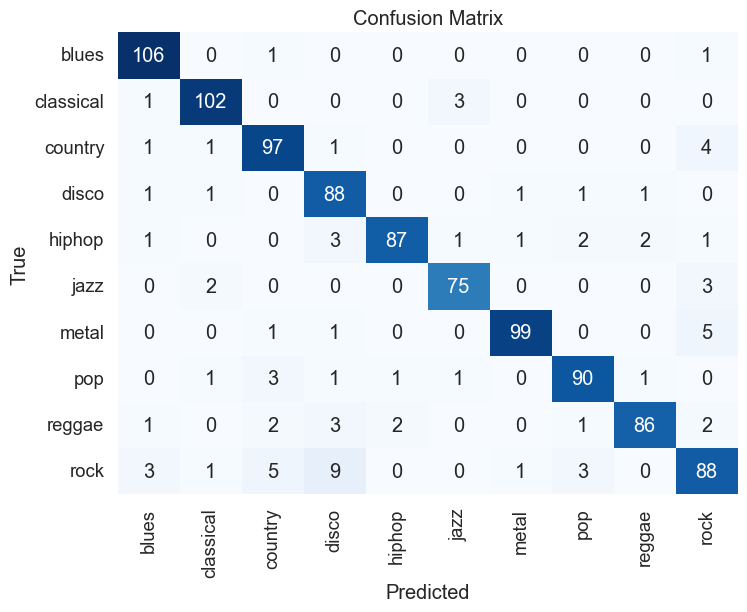

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(test_slices)
y_pred =np.argmax(y_pred, axis=1)
# define classes
classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
